資料前處理

In [35]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./raw_data/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

In [18]:
df = pd.read_csv("./raw_data/expo.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,lily5085,Japan_Travel,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cadence"", ""c...",101.12.146.156,2025-02-21 15:58:15,ptt
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,[問題]九州安排問題，安排長崎旅行,2025-01-17,SLEEPNIGHT,Japan_Travel,四月飛熊本一個人\n\n會玩大概10天\n之後坐船到大阪看萬博\n安排行程有幾個問題請板上建...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dieshichun"",...",42.70.55.203,2025-02-21 15:58:50,ptt
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,[問題]大阪6天5夜行程請教,2025-01-17,abc7119842,Japan_Travel,第1天 (2025/05/15) 早上7點的飛機到關西機場 大概13點到心齋橋附近的飯店\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""a5687920"", ""...",42.77.89.115,2025-02-21 15:58:54,ptt
3,4,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,[食記]大阪城東商店街柑仔店喫茶秘密基地白泉堂,2025-01-19,sakyouz,Japan_Travel,☁☁☁完整圖文網誌版☁☁☁\nhttps://hiyori.cc/article/p/271...,[],202.226.246.110,2025-02-21 15:59:03,ptt
4,5,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,[問題]大阪六天五夜行程請益,2025-01-20,alanhsu100,Japan_Travel,第一次排自由行，大阪六天五夜行程請教\n\n\n5/10(六) 10.25 到關西機場\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""afu46"", ""cmt...",39.9.133.238,2025-02-21 15:59:03,ptt


In [19]:
#資料清理
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,１． 出遊日期： 114/5/16-114/5/26兩個大人（我跟媽媽），全程無自駕。２． ...
1,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,[問題]九州安排問題，安排長崎旅行,2025-01-17,四月飛熊本一個人\n\n會玩大概10天\n之後坐船到大阪看萬博\n安排行程有幾個問題請板上建...,四月飛熊本一個人。會玩大概10天之後坐船到大阪看萬博安排行程有幾個問題請板上建議。熊本結束要...
2,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,[問題]大阪6天5夜行程請教,2025-01-17,第1天 (2025/05/15) 早上7點的飛機到關西機場 大概13點到心齋橋附近的飯店\n...,第1天 (2025/05/15) 早上7點的飛機到關西機場 大概13點到心齋橋附近的飯店心齋...
3,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,[食記]大阪城東商店街柑仔店喫茶秘密基地白泉堂,2025-01-19,☁☁☁完整圖文網誌版☁☁☁\nhttps://hiyori.cc/article/p/271...,☁☁☁完整圖文網誌版☁☁☁ 和大阪萬博同年在1970開業，乍看是間販售古早味的柑仔店，橘色沙...
4,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,[問題]大阪六天五夜行程請益,2025-01-20,第一次排自由行，大阪六天五夜行程請教\n\n\n5/10(六) 10.25 到關西機場\n...,第一次排自由行，大阪六天五夜行程請教。5/10(六) 10.25 到關西機場。 搭南海...


In [21]:
#斷句
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,１． 出遊日期： 114/5/16-114/5/26兩個大人（我跟媽媽）
1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,全程無自駕
2,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,２． 每日行程：
3,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,5/1612:05到關西機場
4,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,下午心齋橋或梅田逛逛住：大阪車站附近飯店5/17萬國博覽會住：大阪車站附近飯店5/18萬國博...


In [22]:
#匯入斷詞字典
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/expo_dict.txt')

Building prefix dict from c:\Users\User\OneDrive\桌面\社群媒體分析\SMA_2025S\社媒期末專案\dict\dict.txt ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u75f7e282025976d857073c78ba4d330e.cache
Loading model cost 0.650 seconds.
Prefix dict has been built successfully.


In [23]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,１ 出遊日期 114516114526兩個大人我跟媽媽
1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,全程無自駕
2,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,２ 每日行程
3,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,5161205到關西機場
4,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,下午心齋橋或梅田逛逛住大阪車站附近飯店517萬國博覽會住大阪車站附近飯店518萬國博覽會or...


In [24]:
#文章斷詞
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,出遊
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,日期
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,114516114526
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,兩個
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,大人


In [26]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,出遊
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,日期
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,114516114526
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,兩個
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,大人


進行情緒分析

In [28]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [29]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,2025-01-10,[問題]關西北陸五月行程請益,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,出遊,NaN
1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,2025-01-10,[問題]關西北陸五月行程請益,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,日期,NaN
2,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,2025-01-10,[問題]關西北陸五月行程請益,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,114516114526,NaN
3,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,2025-01-10,[問題]關西北陸五月行程請益,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,兩個,NaN
4,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,2025-01-10,[問題]關西北陸五月行程請益,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,大人,NaN


In [30]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

,artDate,sentiments,size
2,2025-01-10,negative,4
3,2025-01-10,positive,2
5,2025-01-17,negative,3
6,2025-01-17,positive,1
10,2025-01-19,negative,3
11,2025-01-19,positive,12
13,2025-01-20,positive,1
15,2025-01-22,negative,1
16,2025-01-22,positive,2
18,2025-02-07,positive,2


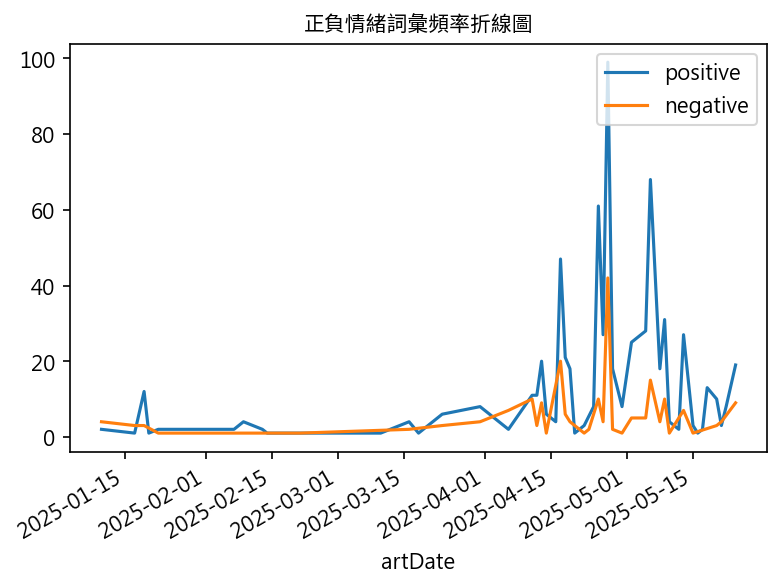

In [36]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

因為萬博的開幕日為2025/04/13，所以可以發現4月後的討論度明顯變高。以及在開幕日前，以及有些對大阪萬博的負評，但是實際跑完分析後，會發現其實正向評論和負向評論是差不多的，所以大家腦中常常出現的萬博負面評論，有可能是被媒體刻意放大報導，或是社群平台發送的資訊偏頗。

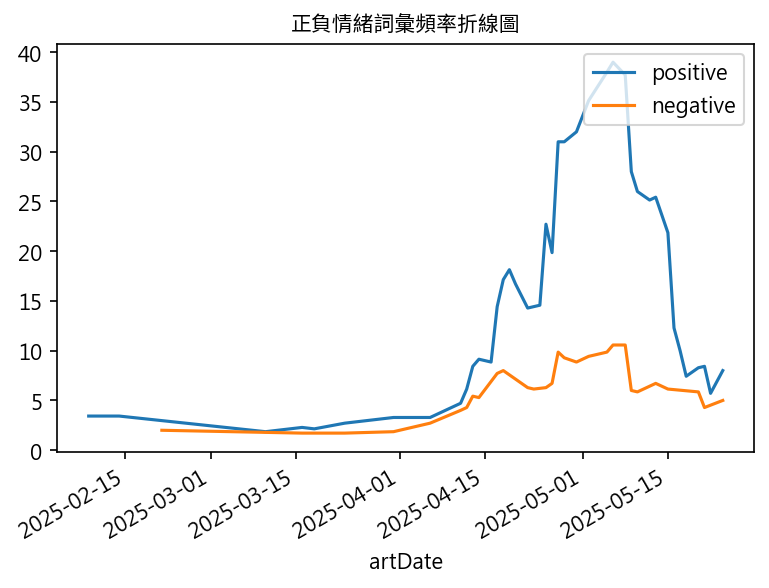

In [42]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 7 天平均
rolling_days = 7
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

In [45]:
#用頻率的方式觀察趨勢
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

,artDate,sentiments,size,ratio
2,2025-01-10,negative,4,0.666667
3,2025-01-10,positive,2,0.333333
5,2025-01-17,negative,3,0.750000
6,2025-01-17,positive,1,0.250000
10,2025-01-19,negative,3,0.200000
11,2025-01-19,positive,12,0.800000
13,2025-01-20,positive,1,1.000000
15,2025-01-22,negative,1,0.333333
16,2025-01-22,positive,2,0.666667
18,2025-02-07,positive,2,1.000000


Text(0.5, 1.0, '正負情緒比例折線圖')

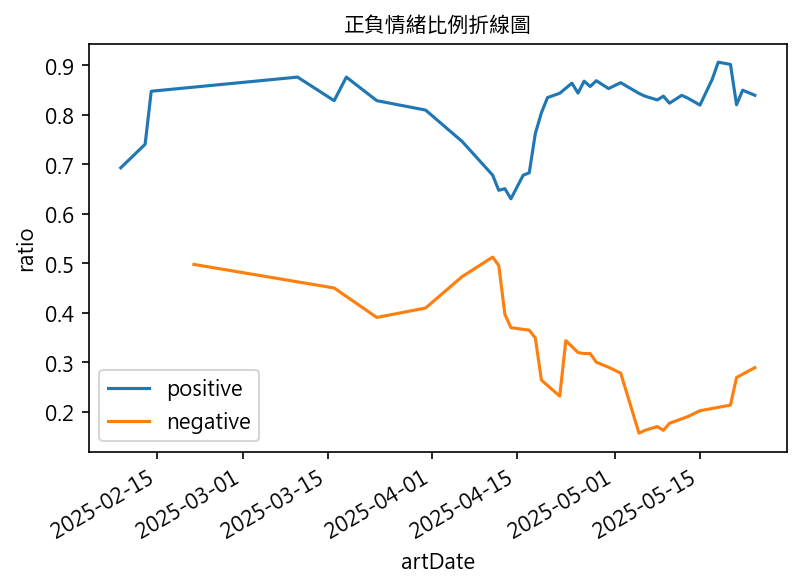

In [66]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 7
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

In [47]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2025-01-10,4.0,2.0
1,2025-01-17,3.0,1.0
2,2025-01-19,3.0,12.0
3,2025-01-20,0.0,1.0
4,2025-01-22,1.0,2.0


In [48]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2025-01-10,4.0,2.0,-2.0
1,2025-01-17,3.0,1.0,-2.0
2,2025-01-19,3.0,12.0,9.0
3,2025-01-20,0.0,1.0,1.0
4,2025-01-22,1.0,2.0,1.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

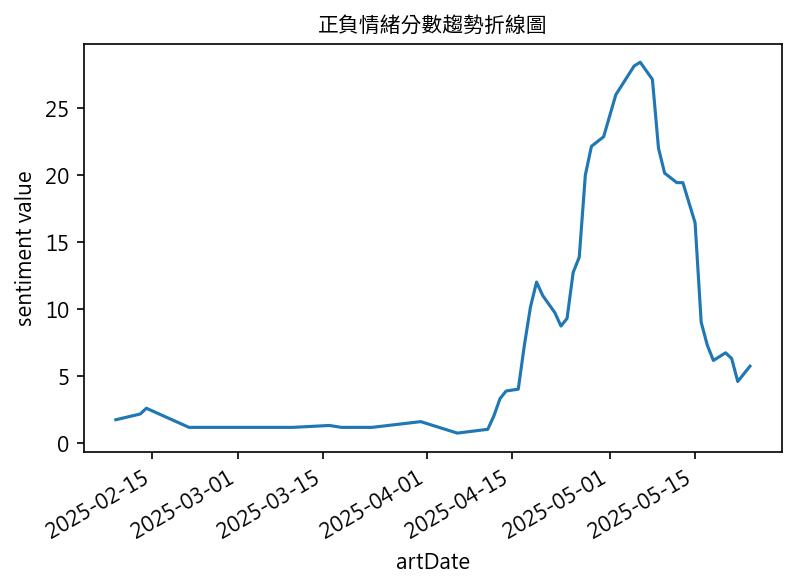

In [67]:
fig, ax = plt.subplots()

rolling_days = 7
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

以文章為單位

In [50]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,affect,6
1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,anx,1
2,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,negative,4
3,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,positive,2
4,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,affect,3
5,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,negative,2
6,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,affect,3
7,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,negative,1
8,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,positive,1
9,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,affect,18


In [51]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,6.0,0.0,1.0,4.0,2.0,0.0
1,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,3.0,0.0,0.0,2.0,0.0,0.0
2,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,3.0,0.0,0.0,1.0,1.0,0.0
3,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,18.0,1.0,2.0,3.0,12.0,0.0
4,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,1.0,0.0,0.0,0.0,1.0,0.0


In [52]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,6.0,0.0,1.0,4.0,2.0,0.0,-2.0
1,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,3.0,0.0,0.0,2.0,0.0,0.0,-2.0
2,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,3.0,0.0,0.0,1.0,1.0,0.0,0.0
3,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,18.0,1.0,2.0,3.0,12.0,0.0,9.0
4,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [53]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,6.0,0.0,1.0,4.0,2.0,0.0,-2.0,負向
1,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,3.0,0.0,0.0,2.0,0.0,0.0,-2.0,負向
2,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,3.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
3,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,18.0,1.0,2.0,3.0,12.0,0.0,9.0,正向
4,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
5,https://www.ptt.cc/bbs/Japan_Travel/M.17375287...,3.0,0.0,0.0,1.0,2.0,0.0,1.0,正向
6,https://www.ptt.cc/bbs/Japan_Travel/M.17389039...,3.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
7,https://www.ptt.cc/bbs/Japan_Travel/M.17391152...,5.0,0.0,0.0,1.0,4.0,0.0,3.0,正向
8,https://www.ptt.cc/bbs/Japan_Travel/M.17393797...,3.0,0.0,0.0,1.0,2.0,0.0,1.0,正向
9,https://www.ptt.cc/bbs/Japan_Travel/M.17395387...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向


In [54]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.17364939...,[問題]關西北陸五月行程請益,2025-01-10,lily5085,Japan_Travel,１． 出遊日期： 114/5/16-114/5/26\n兩個大人（我跟媽媽），全程無自駕\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cadence"", ""c...",101.12.146.156,2025-02-21 15:58:15,ptt,負向
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.17370741...,[問題]九州安排問題，安排長崎旅行,2025-01-17,SLEEPNIGHT,Japan_Travel,四月飛熊本一個人\n\n會玩大概10天\n之後坐船到大阪看萬博\n安排行程有幾個問題請板上建...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dieshichun"",...",42.70.55.203,2025-02-21 15:58:50,ptt,負向
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.17371036...,[問題]大阪6天5夜行程請教,2025-01-17,abc7119842,Japan_Travel,第1天 (2025/05/15) 早上7點的飛機到關西機場 大概13點到心齋橋附近的飯店\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""a5687920"", ""...",42.77.89.115,2025-02-21 15:58:54,ptt,負向
3,4,https://www.ptt.cc/bbs/Japan_Travel/M.17372969...,[食記]大阪城東商店街柑仔店喫茶秘密基地白泉堂,2025-01-19,sakyouz,Japan_Travel,☁☁☁完整圖文網誌版☁☁☁\nhttps://hiyori.cc/article/p/271...,[],202.226.246.110,2025-02-21 15:59:03,ptt,正向
4,5,https://www.ptt.cc/bbs/Japan_Travel/M.17373541...,[問題]大阪六天五夜行程請益,2025-01-20,alanhsu100,Japan_Travel,第一次排自由行，大阪六天五夜行程請教\n\n\n5/10(六) 10.25 到關西機場\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""afu46"", ""cmt...",39.9.133.238,2025-02-21 15:59:03,ptt,正向


In [55]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2025-01-10,負向,1
1,2025-01-17,負向,2
2,2025-01-19,正向,1
3,2025-01-20,正向,1
4,2025-01-22,正向,1
5,2025-02-07,正向,1
6,2025-02-09,正向,1
7,2025-02-13,正向,1
8,2025-02-14,正向,1
9,2025-02-21,負向,1


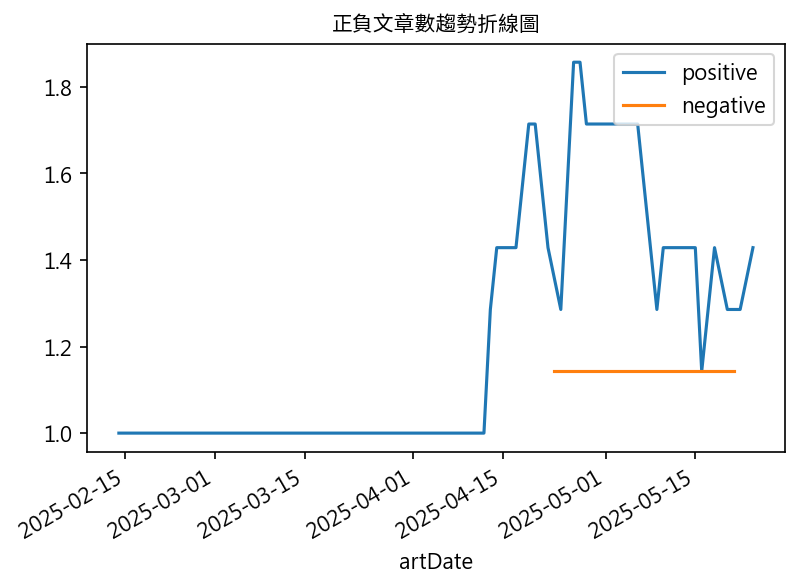

In [78]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 7 天平均
rolling_days = 7
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

情緒代表字

In [60]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

,word,sentiments,size
98,問題,negative,41
97,問題,affect,41
11,不錯,positive,34
10,不錯,affect,34
106,喜歡,positive,33
105,喜歡,affect,33
33,值得,positive,33
32,值得,affect,33
141,好吃,positive,29
140,好吃,affect,29


In [61]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
11,不錯,positive,34
106,喜歡,positive,33
33,值得,positive,33
141,好吃,positive,29
180,希望,positive,29
55,分享,positive,26
319,朋友,positive,26
436,簡單,positive,19
238,感謝,positive,16
344,決定,positive,16


In [62]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
98,問題,negative,41
280,擔心,negative,10
380,無聊,negative,10
555,隨便,negative,8
582,麻煩,negative,8
294,放棄,negative,8
250,戰鬥,negative,6
540,錯過,negative,5
538,錯誤,negative,5
131,失敗,negative,4


C:\Users\User\AppData\Local\Temp\ipykernel_13524\391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\User\AppData\Local\Temp\ipykernel_13524\391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

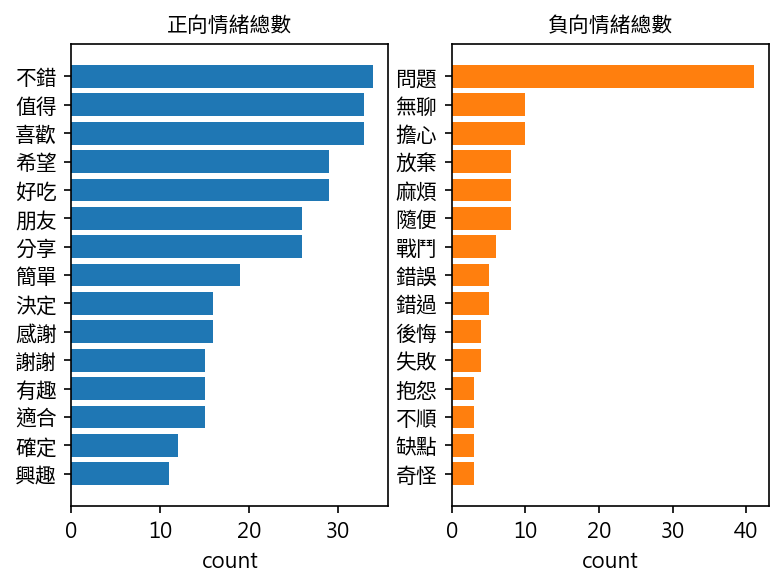

In [63]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [64]:
filtered_df = sent_df[sent_df['sentence'].str.contains('無聊', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
1414,https://www.ptt.cc/bbs/Japan_Travel/M.17449921...,[遊記]山陰廣島16日Hybrid獨旅(上),2025-04-19,造訪日期：2024/11\n工作前抓個空檔去山陰、隱岐、廣島獨旅\n規劃行程時參考了板上眾多...,搭乘高速巴士的體驗其實不錯不用擔心行李沒位置放車上也有廁所沿路會停靠在一個休息站十分鐘不過我...
2043,https://www.ptt.cc/bbs/Japan_Travel/M.17455980...,[遊記]大阪萬博參觀分享(下)：推薦館別與心得,2025-04-26,造訪日期：2025.4\n有圖部落格版：\nhttps://lihi2.com/kbaIl/...,讓排隊的人不無聊
2128,https://www.ptt.cc/bbs/Japan_Travel/M.17455980...,[遊記]大阪萬博參觀分享(下)：推薦館別與心得,2025-04-26,造訪日期：2025.4\n有圖部落格版：\nhttps://lihi2.com/kbaIl/...,有些有點無聊妘ㄕ陳齈D示範但應該都是日文
3253,https://www.ptt.cc/bbs/Japan_Travel/M.17464560...,[遊記]大阪萬博20個場館簡評,2025-05-05,我昨天跟今天（5/4-5/5）剛去完萬博，以下提供萬博20個場館簡評。不過這是阿宅帶有強烈主...,我看幾分鐘就無聊到閃人了
3324,https://www.ptt.cc/bbs/Japan_Travel/M.17464560...,[遊記]大阪萬博20個場館簡評,2025-05-05,我昨天跟今天（5/4-5/5）剛去完萬博，以下提供萬博20個場館簡評。不過這是阿宅帶有強烈主...,有點無聊


In [65]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

搭乘高速巴士的體驗其實不錯不用擔心行李沒位置放車上也有廁所沿路會停靠在一個休息站十分鐘不過我做了一個迷惑行為這台車上有放腳的踏板我一開始是直接放上去後來無聊時看了一下網袋內的說明才發現是要脫鞋
讓排隊的人不無聊
有些有點無聊妘ㄕ陳齈D示範但應該都是日文
我看幾分鐘就無聊到閃人了
有點無聊
Day5萬博 其實這天我覺得蠻無聊的 人一堆到處都要排隊 抽到魔物XR但我根本沒玩過魔物覺得還好抽到了寶塚 但 嗯 很好睡 科威特館還不錯義大利館排兩個小時 內容也不是太吸引我null當天抽券的館也很無聊 還不如ZUTOMAYO的舞台演出去看了月海つくね的anisong盆舞 也比想像中尷尬水舞演出感覺還好大概只有這個無人機比較酷  總之再讓我選一次一定不來或是走一圈把建築拍完就好
送台灣黑熊造型毛巾1830現場排原子小金剛展介紹未來醫療科技跟睡眠艙1945鋼彈館當日抽到跟著鋼彈動畫一起到宇宙2020前3天搶到いのち動的平衡館燈光秀有點無聊在展館內超難預約展館外面超好預約建議自備地圖跟門票qr扣工作人員對於場館分布圖不太熟悉
但除此之外我覺得蠻無聊的
還有專用AR APP讓你排隊等待時不會太無聊
